In [198]:
import os
import h5py
import re
from scipy.io import loadmat
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict


In [10]:
# Choose which days to include
#day_list = ['20181105', '20181102', '20181101']

# Or, read in list of days from txt file
day_list = list()
with open(f'data/combined/days.txt', 'r') as file:
    for line in file:
        day_list.append(line.strip())

num_sess = len(day_list)
num_goals = 6
tbin_size = 0.1

In [219]:
# Save directory for data files
prefix = "/Volumes/Hippocampus/Data/picasso-misc/"
save_dir = "data/placedist"
# Whether to overwrite preexisting files
overwrite = True
# Save Figures
to_save = True
figsave_dir = 'figures/population_prob_distribution'

In [12]:
good_cell_labels = list()
with open(f'{save_dir}/sub_psuedopop_cells.txt', 'r') as file:
    for line in file:
        good_cell_labels.append(line.strip())
print(good_cell_labels)

['20180917ch45c1', '20181011ch20c1', '20181015ch20c1', '20181011ch45c2', '20180813ch86c1', '20180827ch29c1', '20180810ch38c1', '20181101ch29c4', '20180730ch43c2', '20180903ch20c1', '20180813ch45c1', '20180904ch29c1', '20181016ch20c1', '20181015ch45c1', '20180910ch17c1', '20181102ch29c1', '20181009ch45c4', '20180828ch45c1', '20180907ch20c2', '20181005ch45c3', '20180731ch45c1', '20181031ch30c1', '20180925ch45c2', '20181022ch9c1', '20180827ch45c1', '20181001ch20c2', '20181101ch30c2', '20180828ch20c1', '20180906ch20c1', '20181105ch29c1', '20181016ch45c1', '20180920ch45c1', '20180829ch45c3', '20181001ch76c1', '20180829ch6c2', '20180814ch45c2', '20181102ch30c1', '20181015ch29c1', '20180813ch21c1', '20180925ch29c1', '20180920ch17c1', '20180705ch76c1', '20180928ch45c2', '20181102ch19c1', '20180913ch20c1', '20180905ch29c1', '20180918ch34c1', '20180906ch29c1', '20181010ch45c1', '20180914ch20c2']


In [14]:
bins_data_sub_pop = {}
for day in day_list:
    with open(f'{save_dir}/{day}_data.pkl', 'rb') as file:
        data = pickle.load(file)
        place_responses_per_cell = data['place_responses_per_cell']
        cell_labels = data['cell_labels']
    for cell, label in enumerate(cell_labels):
        if label not in good_cell_labels:
            continue
        for bin, dist in place_responses_per_cell[cell].items():
            dist = dist[dist > 0]
            if bin not in bins_data_sub_pop:
                bins_data_sub_pop[bin] = []
            bins_data_sub_pop[bin].append(dist)

In [15]:
for key, distributions in bins_data_sub_pop.items():
    for i in range(len(distributions)):
        distribution = distributions[i]
        total = sum(distribution)
        distributions[i] = [float(i) / total for i in distribution]

In [19]:
all_place_responses = list()
all_place_durations = list()
all_cell_labels = list()

for day in day_list:
    with open(f'{save_dir}/{day}_data.pkl', 'rb') as file:
        data = pickle.load(file)
        num_sess_cells = len(data['cell_labels'])
        for i in range(num_sess_cells):
            cell_label = data['cell_labels'][i]
            if cell_label in good_cell_labels:
                all_place_responses.append(data['place_responses_per_cell'][i])
                all_place_durations.append(data['durations_per_place'])
                all_cell_labels.append(cell_label)

num_all_cells = len(all_cell_labels)
print(all_cell_labels)

['20181105ch29c1', '20181102ch19c1', '20181102ch29c1', '20181102ch30c1', '20181101ch29c4', '20181101ch30c2', '20181031ch30c1', '20181022ch9c1', '20181016ch20c1', '20181016ch45c1', '20181015ch20c1', '20181015ch29c1', '20181015ch45c1', '20181011ch20c1', '20181011ch45c2', '20181010ch45c1', '20181009ch45c4', '20181005ch45c3', '20181001ch20c2', '20181001ch76c1', '20180928ch45c2', '20180925ch29c1', '20180925ch45c2', '20180920ch17c1', '20180920ch45c1', '20180918ch34c1', '20180917ch45c1', '20180914ch20c2', '20180913ch20c1', '20180910ch17c1', '20180907ch20c2', '20180906ch20c1', '20180906ch29c1', '20180905ch29c1', '20180904ch29c1', '20180903ch20c1', '20180829ch6c2', '20180829ch45c3', '20180828ch20c1', '20180828ch45c1', '20180827ch29c1', '20180827ch45c1', '20180814ch45c2', '20180813ch21c1', '20180813ch45c1', '20180813ch86c1', '20180810ch38c1', '20180731ch45c1', '20180730ch43c2', '20180705ch76c1']


In [20]:
for cell, place_responses_per_cell in enumerate(all_place_responses):
    num_bins = 25
    response_params_per_cell = np.zeros((num_bins+1, 3))
    place_durations_per_cell = all_place_durations[cell]
    for bin, dist in place_responses_per_cell.items():
        total = sum(dist)
        dist= [float(i) / total for i in dist]
        response_params_per_cell[bin,0] = np.mean(dist)
        response_params_per_cell[bin,1] = np.std(dist, ddof=1)
        response_params_per_cell[bin,2] = np.sum(place_durations_per_cell[bin])
    response_params_per_cell[:,2] = response_params_per_cell[:,2] / np.sum(response_params_per_cell[:,2])
    all_place_responses[cell] = response_params_per_cell
all_place_responses = np.array(all_place_responses)

# Clean up large memory variables
del all_place_durations

In [70]:
from scipy.stats import lognorm
from scipy.stats import expon
from collections import Counter

class BayesCellDecoder:
    def __init__(self, dist):
        self.dist = dist
        self.num_cells = dist.shape[0]
        self.num_bins = dist.shape[1]
        
    def gaussian_pdf(x, mu, sig):
        return (1 / np.sqrt(2 * np.pi * sig**2)) * np.exp(-(x - mu)**2 / (2 * sig**2))
    
    def __likelihood(self, x, cell, bin):
        mu, sig = self.dist[cell,bin,0], self.dist[cell,bin,1]
        return BayesCellDecoder.gaussian_pdf(x, mu, sig)
    
    def __predict_cell(self, x, cell):
        posterior = np.zeros(self.num_bins)
        for bin in range(1, self.num_bins):
            prior = self.dist[cell,bin,2]
            posterior[bin] = prior * self.__likelihood(x, cell, bin)
        posterior = np.nan_to_num(posterior, nan=-np.inf, posinf=np.inf, neginf=-np.inf)
        pred = np.argmax(posterior[1:])
        return pred, posterior[pred] 

    def predict(self, x):
        prediction, confidence = np.zeros(self.num_cells), np.zeros(self.num_cells)
        for cell in range(self.num_cells):
            pred, conf = self.__predict_cell(x[cell], cell)
            prediction[cell] = pred
            confidence[cell] = conf
        unique_preds, counts = np.unique(prediction, return_counts=True)
        #return lines
        most_common_pred = unique_preds[np.argmax(counts)]
        counts = Counter(prediction)
        most_common = counts.most_common(1)
        total_count = len(prediction)
        unique_proportions = {int(unique + 1): f'{round((count / total_count) * 100, 2)}%' for unique, count in counts.items()}
        cleaned_proportions = {k: float(v.strip('%')) for k, v in unique_proportions.items()}

        top_three_bins = [num + 1 for num, _ in most_common]
        data_array = np.array(prediction)
        incremented_data = data_array + 1
        return incremented_data 
    

In [71]:
place_decoder_cells = BayesCellDecoder(all_place_responses)
print(len(good_cell_labels))

50


In [195]:
# Refresh averages
from collections import defaultdict

cumulative_sums = [1, 2, 3, 4, 5, 6, 8, 10, 11, 12, 13, 14, 15, 16, 18, 20, 21, 22, 23, 24, 25]
cumulative_sums = {key: 0 for key in cumulative_sums}

num_runs = 0

In [168]:
def update_running_average(key, most_common_int):
    if key == most_common_int:
        cumulative_sums[key] += 1 

In [203]:
def proportion_string(cumulative_sums, num_runs):
    list_proportions = []
    for key in cumulative_sums:
        numerator = cumulative_sums[key]
        proportion = f'{numerator}/{num_runs}'
        list_proportions.append(proportion)
    return list_proportions

In [196]:
num_runs_loop = 2500
for _ in range(num_runs_loop):
    random_values = {}
    num_runs += 1

    for key, distributions in bins_data_sub_pop.items():
        key_random_values = [random.choice(distribution) for distribution in distributions]
        random_values[key] = key_random_values
        
    predictions = {}
    for key in bins_data_sub_pop.keys():
        bin_prediction_list = random_values[key]
        predicted_bin = place_decoder_cells.predict(bin_prediction_list)
        counter = Counter(predicted_bin)
        most_common = counter.most_common(1)
        most_common_int, count = most_common[0]
        if int(most_common_int) == int(key):
            print(f"The predicted bin is {int(most_common_int)}")
        else: 
            print(f"The predicted bin is {int(most_common_int)} which was not {key}")
        
        update_running_average(key, most_common_int)


/var/folders/x9/1nq85w8s11l0sv1yqg3364200000h2/T/ipykernel_5703/2713236929.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return (1 / np.sqrt(2 * np.pi * sig**2)) * np.exp(-(x - mu)**2 / (2 * sig**2))
/var/folders/x9/1nq85w8s11l0sv1yqg3364200000h2/T/ipykernel_5703/2713236929.py:12: RuntimeWarning: invalid value encountered in double_scalars
  return (1 / np.sqrt(2 * np.pi * sig**2)) * np.exp(-(x - mu)**2 / (2 * sig**2))


The predicted bin is 15 which was not 3
The predicted bin is 12 which was not 8
The predicted bin is 13
The predicted bin is 13 which was not 18
The predicted bin is 15 which was not 23
The predicted bin is 16 which was not 24
The predicted bin is 13 which was not 12
The predicted bin is 13 which was not 11
The predicted bin is 16
The predicted bin is 13 which was not 14
The predicted bin is 15
The predicted bin is 16 which was not 10
The predicted bin is 21 which was not 5
The predicted bin is 1 which was not 4
The predicted bin is 15 which was not 2
The predicted bin is 24 which was not 6
The predicted bin is 25 which was not 1
The predicted bin is 21
The predicted bin is 25 which was not 22
The predicted bin is 25
The predicted bin is 15 which was not 20
The predicted bin is 24 which was not 3
The predicted bin is 12 which was not 8
The predicted bin is 13
The predicted bin is 13 which was not 18
The predicted bin is 14 which was not 23
The predicted bin is 15 which was not 24
The p

In [208]:
#proportions = proportion_string(cumulative_sums, num_runs)
bins = [1, 2, 3, 4, 5, 6, 8, 10, 11, 12, 13, 14, 15, 16, 18, 20, 21, 22, 23, 24, 25]
for proportion in proportions:
    print(proportion)
proportions_dict = {bin_key: proportion for bin_key, proportion in zip(bins, proportions)}
print(proportions_dict)


1513/2500
345/2500
0/2500
3/2500
1660/2500
0/2500
1/2500
85/2500
134/2500
21/2500
2500/2500
17/2500
1322/2500
1296/2500
0/2500
0/2500
2477/2500
44/2500
20/2500
1006/2500
1817/2500
{1: '1513/2500', 2: '345/2500', 3: '0/2500', 4: '3/2500', 5: '1660/2500', 6: '0/2500', 8: '1/2500', 10: '85/2500', 11: '134/2500', 12: '21/2500', 13: '2500/2500', 14: '17/2500', 15: '1322/2500', 16: '1296/2500', 18: '0/2500', 20: '0/2500', 21: '2477/2500', 22: '44/2500', 23: '20/2500', 24: '1006/2500', 25: '1817/2500'}


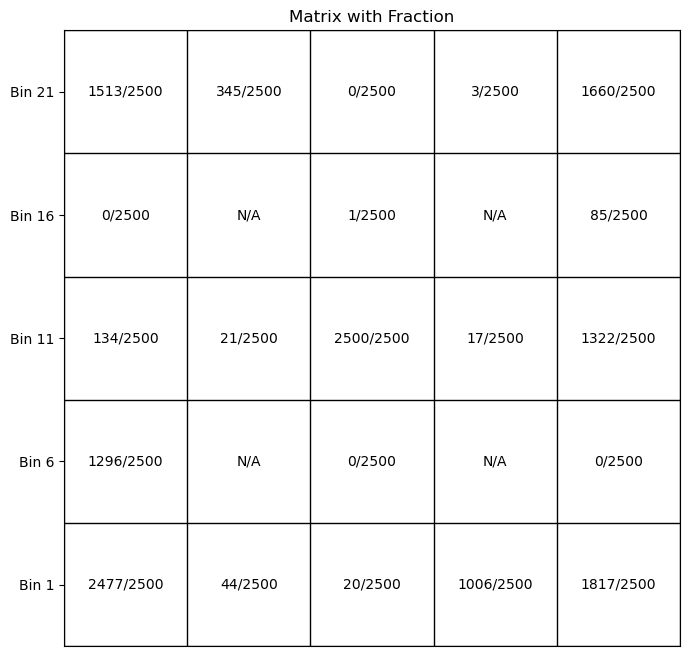

<Figure size 640x480 with 0 Axes>

In [222]:
rows, cols = (len(bins) // 5, 5)  # Adjust size as needed
matrix = np.full((rows, cols), '', dtype=object)

bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
bin_to_index = {bin_num: idx for idx, bin_num in enumerate(bins)}

for idx, bin_num in enumerate(bins):
    row_idx = idx // 5
    col_idx = idx % 5
    if bin_num in [7, 9, 17, 19]:
        matrix[row_idx, col_idx] = 'N/A'
    else:
        matrix[row_idx, col_idx] = proportions_dict.get(bin_num, 'N/A')

fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(np.zeros_like(matrix, dtype=float), cmap='Greys', vmin=0, vmax=1)

for (i, j), val in np.ndenumerate(matrix):
    ax.text(j, i, val, va='center', ha='center', fontsize=10) 

for i in range(rows + 1):
    ax.hlines(i - 0.5, -0.5, cols - 0.5, color='black', lw=1) 
for j in range(cols + 1):
    ax.vlines(j - 0.5, -0.5, rows - 0.5, color='black', lw=1)

ax.set_xticks(ticks=np.arange(0), labels=[])
ax.set_yticks(ticks=np.arange(5), labels=['Bin 21','Bin 16', 'Bin 11', 'Bin 6','Bin 1'])
ax.set_title('Matrix with Proportions')

plt.show()
plt.savefig(f'{figsave_dir}/sub_pop_fractions.png', bbox_inches='tight')


In [224]:
sub_pop_labels = list()
with open(f'{save_dir}/sub_psuedopop_cells.txt', 'r') as file:
    for line in file:
        sub_pop_labels.append(line.strip())
print(sub_pop_labels)
total_labels = len(good_cell_labels)
split_index = int(total_labels * 0.8)  

list_80_percent = good_cell_labels[:split_index]
list_20_percent = good_cell_labels[split_index:]
print("80% of the labels:")
print(list_80_percent)
print("\n20% of the labels:")
print(list_20_percent)

['20180917ch45c1', '20181011ch20c1', '20181015ch20c1', '20181011ch45c2', '20180813ch86c1', '20180827ch29c1', '20180810ch38c1', '20181101ch29c4', '20180730ch43c2', '20180903ch20c1', '20180813ch45c1', '20180904ch29c1', '20181016ch20c1', '20181015ch45c1', '20180910ch17c1', '20181102ch29c1', '20181009ch45c4', '20180828ch45c1', '20180907ch20c2', '20181005ch45c3', '20180731ch45c1', '20181031ch30c1', '20180925ch45c2', '20181022ch9c1', '20180827ch45c1', '20181001ch20c2', '20181101ch30c2', '20180828ch20c1', '20180906ch20c1', '20181105ch29c1', '20181016ch45c1', '20180920ch45c1', '20180829ch45c3', '20181001ch76c1', '20180829ch6c2', '20180814ch45c2', '20181102ch30c1', '20181015ch29c1', '20180813ch21c1', '20180925ch29c1', '20180920ch17c1', '20180705ch76c1', '20180928ch45c2', '20181102ch19c1', '20180913ch20c1', '20180905ch29c1', '20180918ch34c1', '20180906ch29c1', '20181010ch45c1', '20180914ch20c2']
80% of the labels:
['20180917ch45c1', '20181011ch20c1', '20181015ch20c1', '20181011ch45c2', '20180813

In [243]:
bins_data_sub_pop_80 = {}
for day in day_list:
    with open(f'{save_dir}/{day}_data.pkl', 'rb') as file:
        data = pickle.load(file)
        place_responses_per_cell = data['place_responses_per_cell']
        cell_labels = data['cell_labels']
    for cell, label in enumerate(cell_labels):
        if label not in list_80_percent:
            continue
        for bin, dist in place_responses_per_cell[cell].items():
            dist = dist[dist > 0]
            if bin not in bins_data_sub_pop_80:
                bins_data_sub_pop_80[bin] = []
            bins_data_sub_pop_80[bin].append(dist)

In [244]:
bins_data_sub_pop_20 = {}
for day in day_list:
    with open(f'{save_dir}/{day}_data.pkl', 'rb') as file:
        data = pickle.load(file)
        place_responses_per_cell = data['place_responses_per_cell']
        cell_labels = data['cell_labels']
    for cell, label in enumerate(cell_labels):
        if label not in list_20_percent:
            continue
        for bin, dist in place_responses_per_cell[cell].items():
            dist = dist[dist > 0]
            if bin not in bins_data_sub_pop_20:
                bins_data_sub_pop_20[bin] = []
            bins_data_sub_pop_20[bin].append(dist)

In [245]:
for key, distributions in bins_data_sub_pop_80.items():
    for i in range(len(distributions)):
        distribution = distributions[i]
        total = sum(distribution)
        distributions[i] = [float(i) / total for i in distribution]

In [249]:
for key, distributions in bins_data_sub_pop_20.items():
    for i in range(len(distributions)):
        distribution = distributions[i]
        total = sum(distribution)
        distributions[i] = [float(i) / total for i in distribution]

In [251]:
all_place_responses = list()
all_place_durations = list()
all_cell_labels = list()

for day in day_list:
    with open(f'{save_dir}/{day}_data.pkl', 'rb') as file:
        data = pickle.load(file)
        num_sess_cells = len(data['cell_labels'])
        for i in range(num_sess_cells):
            cell_label = data['cell_labels'][i]
            if cell_label in list_80_percent:
                all_place_responses.append(data['place_responses_per_cell'][i])
                all_place_durations.append(data['durations_per_place'])
                all_cell_labels.append(cell_label)

num_all_cells = len(all_cell_labels)
print(all_cell_labels)

['20181105ch29c1', '20181102ch29c1', '20181102ch30c1', '20181101ch29c4', '20181101ch30c2', '20181031ch30c1', '20181022ch9c1', '20181016ch20c1', '20181016ch45c1', '20181015ch20c1', '20181015ch29c1', '20181015ch45c1', '20181011ch20c1', '20181011ch45c2', '20181009ch45c4', '20181005ch45c3', '20181001ch20c2', '20181001ch76c1', '20180925ch29c1', '20180925ch45c2', '20180920ch45c1', '20180917ch45c1', '20180910ch17c1', '20180907ch20c2', '20180906ch20c1', '20180904ch29c1', '20180903ch20c1', '20180829ch6c2', '20180829ch45c3', '20180828ch20c1', '20180828ch45c1', '20180827ch29c1', '20180827ch45c1', '20180814ch45c2', '20180813ch21c1', '20180813ch45c1', '20180813ch86c1', '20180810ch38c1', '20180731ch45c1', '20180730ch43c2']


In [252]:
for cell, place_responses_per_cell in enumerate(all_place_responses):
    num_bins = 25
    response_params_per_cell = np.zeros((num_bins+1, 3))
    place_durations_per_cell = all_place_durations[cell]
    for bin, dist in place_responses_per_cell.items():
        total = sum(dist)
        dist= [float(i) / total for i in dist]
        response_params_per_cell[bin,0] = np.mean(dist)
        response_params_per_cell[bin,1] = np.std(dist, ddof=1)
        response_params_per_cell[bin,2] = np.sum(place_durations_per_cell[bin])
    response_params_per_cell[:,2] = response_params_per_cell[:,2] / np.sum(response_params_per_cell[:,2])
    all_place_responses[cell] = response_params_per_cell
all_place_responses = np.array(all_place_responses)

# Clean up large memory variables
del all_place_durations

In [253]:
from scipy.stats import lognorm
from scipy.stats import expon
from collections import Counter

class BayesTrainTestCellDecoder:
    def __init__(self, dist):
        self.dist = dist
        self.num_cells = dist.shape[0]
        self.num_bins = dist.shape[1]
        
    def gaussian_pdf(x, mu, sig):
        return (1 / np.sqrt(2 * np.pi * sig**2)) * np.exp(-(x - mu)**2 / (2 * sig**2))
    
    def __likelihood(self, x, cell, bin):
        mu, sig = self.dist[cell,bin,0], self.dist[cell,bin,1]
        return BayesTrainTestCellDecoder.gaussian_pdf(x, mu, sig)
    
    def __predict_cell(self, x, cell):
        posterior = np.zeros(self.num_bins)
        for bin in range(1, self.num_bins):
            prior = self.dist[cell,bin,2]
            posterior[bin] = prior * self.__likelihood(x, cell, bin)
        posterior = np.nan_to_num(posterior, nan=-np.inf, posinf=np.inf, neginf=-np.inf)
        pred = np.argmax(posterior[1:])
        return pred, posterior[pred] 

    def predict(self, x):
        prediction, confidence = np.zeros(self.num_cells), np.zeros(self.num_cells)
        for cell in range(self.num_cells):
            pred, conf = self.__predict_cell(x[cell], cell)
            prediction[cell] = pred
            confidence[cell] = conf
        unique_preds, counts = np.unique(prediction, return_counts=True)
        #return lines
        most_common_pred = unique_preds[np.argmax(counts)]
        counts = Counter(prediction)
        most_common = counts.most_common(1)
        total_count = len(prediction)
        unique_proportions = {int(unique + 1): f'{round((count / total_count) * 100, 2)}%' for unique, count in counts.items()}
        cleaned_proportions = {k: float(v.strip('%')) for k, v in unique_proportions.items()}

        top_three_bins = [num + 1 for num, _ in most_common]
        data_array = np.array(prediction)
        incremented_data = data_array + 1
        return incremented_data 
    

In [255]:
place_decoder_cells = BayesTrainTestCellDecoder(all_place_responses)
print(len(list_80_percent))

40


In [281]:
# Refresh averages
from collections import defaultdict

bins = [1, 2, 3, 4, 5, 6, 8, 10, 11, 12, 13, 14, 15, 16, 18, 20, 21, 22, 23, 24, 25]
cumulative_sums_sub = {key: 0 for key in cumulative_sums}

num_sub_runs = 0

In [282]:
def update_running_average(key, most_common_int):
    if key == most_common_int:
        cumulative_sums_sub[key] += 1 
def proportion_string(cumulative_sums_sub, num_runs):
    list_proportions = []
    for key in cumulative_sums_sub:
        numerator = cumulative_sums_sub[key]
        proportion = f'{numerator}/{num_runs}'
        list_proportions.append(proportion)
    return list_proportions

In [283]:
num_runs_loop = 250
def sample_forty_random_values(distributions, num_samples=40):
    all_values = []
    for distribution in distributions:
        all_values.extend(distribution)
    if len(all_values) < num_samples:
        all_values *= (num_samples // len(all_values)) + 1
    sampled_values = random.choices(all_values, k=num_samples)
    
    return sampled_values
for _ in range(num_runs_loop):
    random_values = {}
    num_sub_runs += 1
    random_values = {}

    for key, distributions in bins_data_sub_pop_20.items():
        random_values[key] = sample_forty_random_values(distributions)
    print(random_values)

    predictions = {}
    for key in bins_data_sub_pop_20.keys():
        bin_prediction_list = random_values[key]
        predicted_bin = place_decoder_cells.predict(bin_prediction_list)
        counter = Counter(predicted_bin)
        most_common = counter.most_common(1)
        most_common_int, count = most_common[0]
        if int(most_common_int) == int(key):
            print(f"The predicted bin is {int(most_common_int)}")
        else: 
            print(f"The predicted bin is {int(most_common_int)} which was not {key}")
        
        update_running_average(key, most_common_int)



{3: [0.0040700702973496, 0.0015747746816609186, 0.0066504787804835385, 0.0077859211275546954, 0.0043340341874459065, 0.004149287409325083, 0.008417125274894749, 0.004661246454059108, 0.0038883588107586292, 0.01013431142443261, 0.004535702425988401, 0.020589909431624226, 0.007008788288576314, 0.021662379391981016, 0.0026325804862300673, 0.005875448810043604, 0.011380358202937833, 0.003979319922886062, 0.0012311372473061699, 0.009193151096087863, 0.012808489823660174, 0.008046475399454302, 0.0029199695484305585, 0.04754394703276817, 0.003282155974125804, 0.001652572200363341, 0.017777348770862806, 0.031726692526778864, 0.006413189226650828, 0.001878926630198043, 0.00328941868937152, 0.004604120482173906, 0.0033963764063293725, 0.005276026958565918, 0.003371914669506562, 0.007260848831339124, 0.0017765438897532637, 0.00831433793838016, 0.01629849799386004, 0.033900318198224595], 4: [0.0047030838921527035, 0.01136126831997822, 0.005931100441435994, 0.013824803392395254, 0.00530067779358122

/var/folders/x9/1nq85w8s11l0sv1yqg3364200000h2/T/ipykernel_5703/1030867435.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return (1 / np.sqrt(2 * np.pi * sig**2)) * np.exp(-(x - mu)**2 / (2 * sig**2))
/var/folders/x9/1nq85w8s11l0sv1yqg3364200000h2/T/ipykernel_5703/1030867435.py:12: RuntimeWarning: invalid value encountered in double_scalars
  return (1 / np.sqrt(2 * np.pi * sig**2)) * np.exp(-(x - mu)**2 / (2 * sig**2))


The predicted bin is 13 which was not 24
The predicted bin is 12 which was not 22
The predicted bin is 21
The predicted bin is 23 which was not 16
The predicted bin is 13 which was not 11
The predicted bin is 13 which was not 6
The predicted bin is 21 which was not 1
The predicted bin is 25
The predicted bin is 13 which was not 20
{3: [0.0022055836365417773, 0.0034661835030925098, 0.003724439617960681, 0.003832658419612523, 0.0030078797123099374, 0.03314398970652892, 0.004098206480580264, 0.0035263639768891527, 0.010907638236563157, 0.009596296429774684, 0.003141111052547926, 0.004169112755823259, 0.028989600002880058, 0.004202951350985165, 0.002669891413233243, 0.007110079382346899, 0.02864894738215555, 0.005203030758840169, 0.003096548790465251, 0.055964934491037385, 0.00257411816604631, 0.01488232231312358, 0.0033152561488856494, 0.008909285650419117, 0.005770531597837162, 0.006056192343373876, 0.004050268757638363, 0.005335489068325891, 0.008526986497489149, 0.007819098830579454, 0

In [284]:
proportions = proportion_string(cumulative_sums_sub, num_sub_runs)
bins = [1, 2, 3, 4, 5, 6, 8, 10, 11, 12, 13, 14, 15, 16, 18, 20, 21, 22, 23, 24, 25]
for proportion in proportions:
    print(proportion)
proportions_dict = {bin_key: proportion for bin_key, proportion in zip(bins, proportions)}
print(proportions_dict)


83/250
11/250
0/250
0/250
12/250
0/250
0/250
1/250
0/250
0/250
250/250
0/250
0/250
43/250
0/250
0/250
137/250
1/250
0/250
5/250
64/250
{1: '83/250', 2: '11/250', 3: '0/250', 4: '0/250', 5: '12/250', 6: '0/250', 8: '0/250', 10: '1/250', 11: '0/250', 12: '0/250', 13: '250/250', 14: '0/250', 15: '0/250', 16: '43/250', 18: '0/250', 20: '0/250', 21: '137/250', 22: '1/250', 23: '0/250', 24: '5/250', 25: '64/250'}


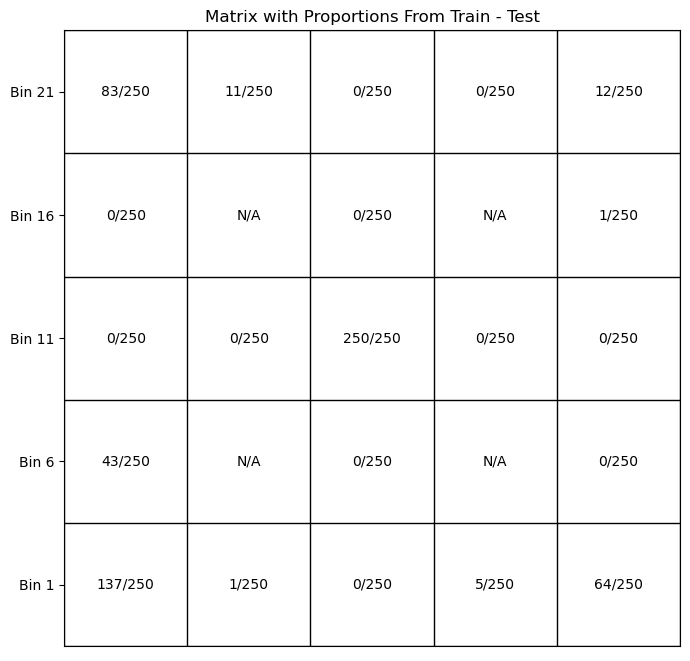

<Figure size 640x480 with 0 Axes>

In [287]:
rows, cols = 5,5  # Adjust size as needed
matrix = np.full((rows, cols), '', dtype=object)

bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
bin_to_index = {bin_num: idx for idx, bin_num in enumerate(bins)}

for idx, bin_num in enumerate(bins):
    row_idx = idx // 5
    col_idx = idx % 5
    if bin_num in [7, 9, 17, 19]:
        matrix[row_idx, col_idx] = 'N/A'
    else:
        matrix[row_idx, col_idx] = proportions_dict.get(bin_num, 'N/A')

fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(np.zeros_like(matrix, dtype=float), cmap='Greys', vmin=0, vmax=1)

for (i, j), val in np.ndenumerate(matrix):
    ax.text(j, i, val, va='center', ha='center', fontsize=10) 

for i in range(rows + 1):
    ax.hlines(i - 0.5, -0.5, cols - 0.5, color='black', lw=1) 
for j in range(cols + 1):
    ax.vlines(j - 0.5, -0.5, rows - 0.5, color='black', lw=1)

ax.set_xticks(ticks=np.arange(0), labels=[])
ax.set_yticks(ticks=np.arange(5), labels=['Bin 21','Bin 16', 'Bin 11', 'Bin 6','Bin 1'])
ax.set_title('Matrix with Proportions From Train - Test')

plt.show()
plt.savefig(f'{figsave_dir}/sub_pop_fractions.png', bbox_inches='tight')
